In [1]:
import pandas
import pandas_profiling as pp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

## data exploration

In [2]:
df = pandas.read_csv("data/train.csv")
df.set_index("PassengerId", inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


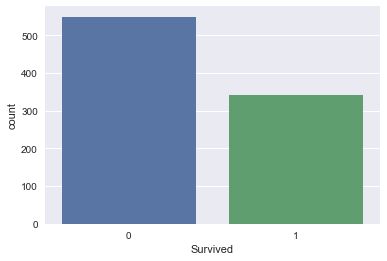

In [3]:
sb.countplot("Survived", data=df);

decently balanced classes.

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


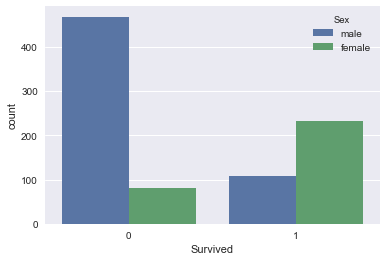

In [4]:
sb.countplot("Survived", data=df, hue="Sex");

this is the baseline.

In [5]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
len(df)

891

In [8]:
pp.ProfileReport(df)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,7
Categorical,4
Date,0
Text (Unique),1
Rejected,0
Distinct count,89


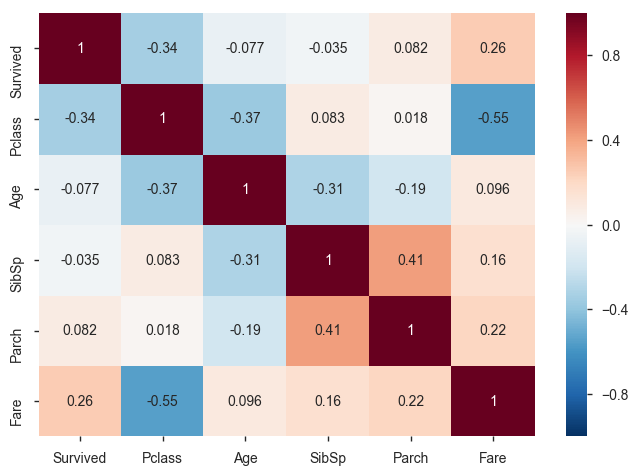

In [9]:
sb.heatmap(df.corr(), annot=True);

## feature engineering

In [10]:
from sklearn_pandas import DataFrameMapper
import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, Imputer, \
                                StandardScaler, OneHotEncoder, FunctionTransformer

In [11]:
mapper = DataFrameMapper([], input_df=True, df_out=True)

### get target variable

In [12]:
mapper.features.append(("Survived", None))

### encode gender

In [13]:
mapper.features.append(("Sex", LabelBinarizer()))

### encode passenger class

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


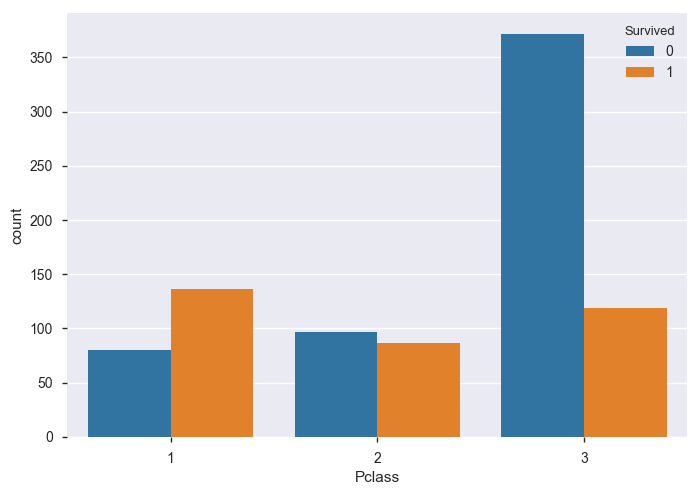

In [14]:
sb.countplot("Pclass", data=df, hue='Survived');

actually encodes some ordinality, so let's leave as-is.

In [15]:
mapper.features.append(("Pclass", None))

### passenger name data

try extracting title from Name:

In [16]:
df.Name.head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [17]:
df['Title'] = df.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1)

In [18]:
class TitleExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1)

In [19]:
TitleExtractor().fit_transform(df.Name)

PassengerId
1          Mr
2         Mrs
3        Miss
4         Mrs
5          Mr
6          Mr
7          Mr
8      Master
9         Mrs
10        Mrs
11       Miss
12       Miss
13         Mr
14         Mr
15       Miss
16        Mrs
17     Master
18         Mr
19        Mrs
20        Mrs
21         Mr
22         Mr
23       Miss
24         Mr
25       Miss
26        Mrs
27         Mr
28         Mr
29       Miss
30         Mr
        ...  
862        Mr
863       Mrs
864      Miss
865        Mr
866       Mrs
867      Miss
868        Mr
869        Mr
870    Master
871        Mr
872       Mrs
873        Mr
874        Mr
875       Mrs
876      Miss
877        Mr
878        Mr
879        Mr
880       Mrs
881       Mrs
882        Mr
883      Miss
884        Mr
885        Mr
886       Mrs
887       Rev
888      Miss
889      Miss
890        Mr
891        Mr
Name: Name, Length: 891, dtype: object

looks good.

In [20]:
df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Jonkheer      1
Don           1
Lady          1
Sir           1
Mme           1
Countess      1
Ms            1
Name: Title, dtype: int64

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


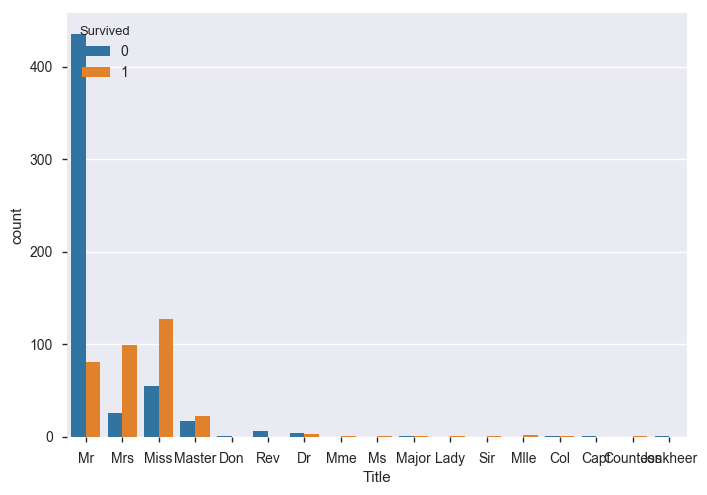

In [21]:
sb.countplot("Title", data=df, hue="Survived");

In [22]:
titles = df.groupby("Title").Survived.agg(["sum", "count"])
(titles['sum']/titles['count']).sort_values(ascending=False)

Title
Sir         1.000000
Lady        1.000000
Ms          1.000000
Countess    1.000000
Mme         1.000000
Mlle        1.000000
Mrs         0.792000
Miss        0.697802
Master      0.575000
Major       0.500000
Col         0.500000
Dr          0.428571
Mr          0.156673
Rev         0.000000
Jonkheer    0.000000
Don         0.000000
Capt        0.000000
dtype: float64

let's try to munge these down to more manageable categories

In [23]:
noble = ("Sir", "Lady", "Countess", "Master", "Count")
adult = ("Mr", "Mrs", "Mme", "Master", "Dr")
young = ("Ms", "Miss", "Mlle")
ranked = ("Col", "Capt", "Major")
other = ("Don", "Jonkheer", "Rev")

def munge_titles(title):
    if title in noble:
        return "noble"
    elif title in adult:
        return "adult"
    elif title in "young":
        return "young"
    elif title in ranked:
        return "ranked"
    else:
        return "other"
    
class TitleMunger(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(munge_titles)

In [24]:
mapper.features.append(("Name", [TitleExtractor(), TitleMunger(), LabelBinarizer()], {"alias": "Title"}))

In [25]:
class NameLengthExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.str.len()

and extract total length of name for shits and giggles.

In [26]:
mapper.features.append(("Name", NameLengthExtractor(), {"alias": "NameLength"}))

### passenger fare

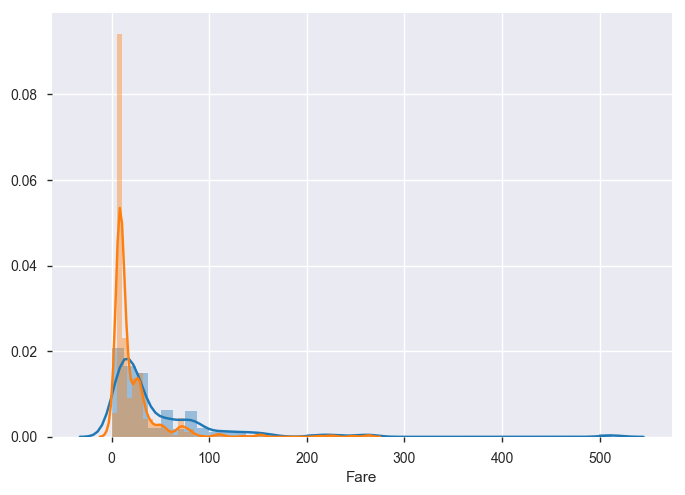

In [27]:
sb.distplot(df[df.Survived == 1].Fare);
sb.distplot(df[df.Survived == 0].Fare);

Cheaper fares more likely to die.  Can probably keep this as is... maybe revisit to log-scale.

In [28]:
mapper.features.append(("Fare", None))

### embarkation point

In [29]:
embark = df.groupby("Embarked").Survived.agg(["sum", "count"])
embark['sum']/embark['count']

Embarked
C    0.553571
Q    0.389610
S    0.336957
dtype: float64

Cherbourg more likely to survive than Queenstown or Southampton.  Presumably class distinction?

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


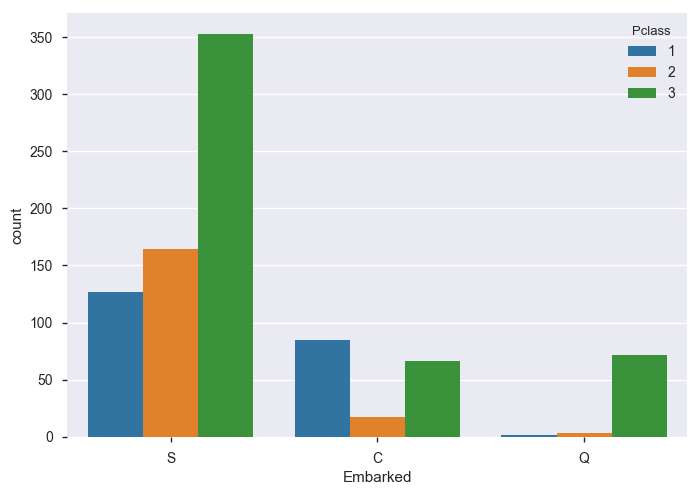

In [30]:
sb.countplot("Embarked", data=df, hue="Pclass");

although the bulk of the passengers were from southampton.

In [31]:
df.Embarked.isnull().sum()

2

In [32]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


let's one-hot encode this.

In [33]:
class CategoricalImputer(TransformerMixin):
    def __init__(self, value=None):
        self.value = value
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [34]:
mapper.features.append(("Embarked", [CategoricalImputer("unknown"), LabelBinarizer()]))

### Age imputation

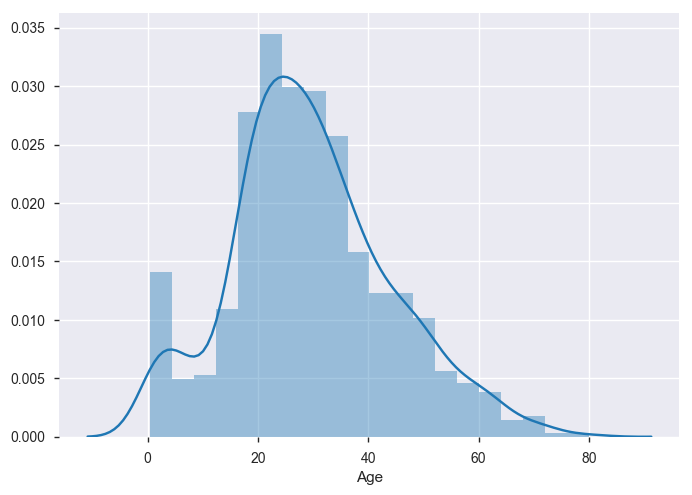

In [35]:
sb.distplot(df[df.Age.notnull()].Age);

problem is the 20% nulls.

In [36]:
df[df.Age.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss
30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,Mr
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Mrs
33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,Miss
37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,Mr


let's impute by gender and class, that should be a decent population representation without overspecifying/getting into sparse data problems.

In [37]:
df.groupby(['Sex', 'Pclass']).Age.mean()

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [38]:
class SmartAgeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ages = X.groupby(['Sex', 'Pclass']).Age.mean()
        
        def impute(row):
            if row.notnull().loc['Age']:
                return row.loc['Age']
            else:
                return ages.loc[(row.loc['Sex'], row.loc['Pclass'])]
            
        return X.apply(impute, axis=1)

In [39]:
SmartAgeImputer().fit_transform(df).head(20)

PassengerId
1     22.000000
2     38.000000
3     26.000000
4     35.000000
5     35.000000
6     26.507589
7     54.000000
8      2.000000
9     27.000000
10    14.000000
11     4.000000
12    58.000000
13    20.000000
14    39.000000
15    14.000000
16    55.000000
17     2.000000
18    30.740707
19    31.000000
20    21.750000
dtype: float64

neat.

In [40]:
mapper.features.append((['Sex', 'Pclass', 'Age'], SmartAgeImputer(), {"alias": "Age"}))

### ticket encoding

In [41]:
df.Ticket

PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
6                330877
7                 17463
8                349909
9                347742
10               237736
11              PP 9549
12               113783
13            A/5. 2151
14               347082
15               350406
16               248706
17               382652
18               244373
19               345763
20                 2649
21               239865
22               248698
23               330923
24               113788
25               349909
26               347077
27                 2631
28                19950
29               330959
30               349216
             ...       
862               28134
863               17466
864            CA. 2343
865              233866
866              236852
867       SC/PARIS 2149
868            PC 17590
869              345777
870              347742
871              349248
872 

In [42]:
def rip_prefix(tx):
    tx = tx.split(' ')
    if len(tx) > 1:
        return tx[0]
    else:
        return ""

In [43]:
df["TicketPrefix"] = df.Ticket.map(rip_prefix)

In [44]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,


In [45]:
df.TicketPrefix.apply(lambda s: s.replace('.', '').replace('/', '')).value_counts()

           665
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
A4           7
SCPARIS      7
SOC          6
STONO2       6
FCC          5
C            5
SCParis      4
SCAH         3
PP           3
WEP          3
SOPP         3
SOTONO2      2
SWPP         2
PPP          2
SCA4         1
SC           1
SP           1
FC           1
Fa           1
SCOW         1
SOP          1
CASOTON      1
AS           1
Name: TicketPrefix, dtype: int64

these might be too gnarly.  Alternate idea: find families traveling under a single ticket, based on instance counts of that ticket ID.

In [46]:
df.groupby('Ticket').size().sort_values(ascending=False)

Ticket
CA. 2343         7
1601             7
347082           7
347088           6
CA 2144          6
3101295          6
S.O.C. 14879     5
382652           5
2666             4
19950            4
PC 17757         4
17421            4
347077           4
349909           4
113760           4
LINE             4
W./C. 6608       4
113781           4
4133             4
248727           3
SC/Paris 2123    3
C.A. 31921       3
29106            3
PC 17760         3
F.C.C. 13529     3
PC 17582         3
PC 17755         3
363291           3
345773           3
371110           3
                ..
349205           1
349206           1
349207           1
349208           1
349209           1
349210           1
349212           1
349213           1
349214           1
349215           1
349216           1
349217           1
349218           1
349221           1
349242           1
349222           1
349223           1
349224           1
349225           1
349227           1
349228           1
34923

In [47]:
class TicketSizeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        sizes = X.value_counts()
        
        def impute(val):
            return sizes.loc[val]
        
        return X.map(impute)

In [48]:
TicketSizeImputer().fit_transform(df.Ticket).head(20)

PassengerId
1     1
2     1
3     1
4     2
5     1
6     1
7     1
8     4
9     3
10    2
11    2
12    1
13    1
14    7
15    1
16    1
17    5
18    1
19    1
20    1
Name: Ticket, dtype: int64

In [49]:
mapper.features.append(("Ticket", TicketSizeImputer(), {"alias": "TicketSize"}))

### cabin allocation

In [50]:
df.Cabin.isnull().sum()

687

mostly nulls.

In [51]:
df['HasCabin'] = df.Cabin.notnull()

In [52]:
df[['Survived', 'HasCabin']].head(10)

,Survived,HasCabin
PassengerId,,
1,0,False
2,1,True
3,1,False
4,1,True
5,0,False
6,0,False
7,0,True
8,0,False
9,1,False


In [53]:
df.groupby('HasCabin').Survived.agg(['sum', 'count'])

,sum,count
HasCabin,,
False,206,687
True,136,204


cabin allocation is much more likely to survive?  correlated to higher classes, perhaps.

In [54]:
df.groupby(['Pclass', 'HasCabin']).Survived.agg(['sum', 'count'])

sum  count
Pclass HasCabin            
1      False      19     40
       True      117    176
2      False      74    168
       True       13     16
3      False     113    479
       True        6     12

in lower classes, having a cabin assigned makes you more likely to survive.

In [55]:
def rip_deck(cabin):
    try:
        return cabin[0]
    except:
        return "no_cabin"

In [56]:
df.Cabin.map(rip_deck).value_counts()

no_cabin    687
C            59
B            47
D            33
E            32
A            15
F            13
G             4
T             1
Name: Cabin, dtype: int64

In [57]:
df['Deck'] = df.Cabin.map(rip_deck)

In [58]:
df.groupby(['Deck']).Survived.agg(['sum', 'count']).apply(lambda row: row['sum']/row['count'], axis=1)

Deck
A           0.466667
B           0.744681
C           0.593220
D           0.757576
E           0.750000
F           0.615385
G           0.500000
T           0.000000
no_cabin    0.299854
dtype: float64

In [59]:
df.groupby(['Pclass', 'Deck']).Survived.agg(['sum', 'count'])

sum  count
Pclass Deck                
1      A           7     15
       B          35     47
       C          35     59
       D          22     29
       E          18     25
       T           0      1
       no_cabin   19     40
2      D           3      4
       E           3      4
       F           7      8
       no_cabin   74    168
3      E           3      3
       F           1      5
       G           2      4
       no_cabin  113    479

let's keep this.

In [60]:
class DeckImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.map(rip_deck)

In [61]:
mapper.features.append(('Cabin', [DeckImputer(), LabelBinarizer()], {"alias": "Deck"}))

### family size

similarly, want to encode total family size from `Parch` and `SibSp` (parent-child and sibling/spouse relationships respectively)

In [62]:
mapper.features.append(("Parch", None))
mapper.features.append(("SibSp", None))

In [63]:
class FamilySize(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['Parch'] + X['SibSp']

In [64]:
mapper.features.append((["Parch", "SibSp"], FamilySize(), {"alias": "FamilySize"}))

In [65]:
mapper.fit_transform(df)

,Survived,Sex,Pclass,Title_adult,Title_noble,Title_other,Title_ranked,NameLength,Fare,Embarked_C,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_no_cabin,Parch,SibSp,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,3.0,1.0,0.0,0.0,0.0,23.0,7.2500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,51.0,71.2833,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,3.0,0.0,0.0,1.0,0.0,22.0,7.9250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,44.0,53.1000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,1.0,3.0,1.0,0.0,0.0,0.0,24.0,8.0500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,3.0,1.0,0.0,0.0,0.0,16.0,8.4583,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,0.0,0.0,0.0,23.0,51.8625,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,3.0,0.0,1.0,0.0,0.0,30.0,21.0750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0
9,1.0,0.0,3.0,1.0,0.0,0.0,0.0,49.0,11.1333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0


let's go with it.

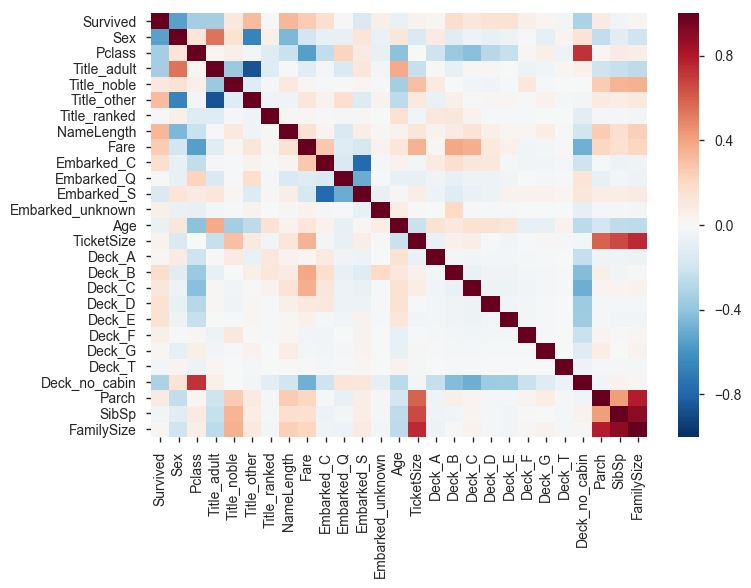

In [66]:
sb.heatmap(mapper.transform(df).corr());

In [67]:
mapper.transform(df).corr()['Survived'].sort_values()

Sex                -0.543351
Title_adult        -0.340268
Pclass             -0.338481
Deck_no_cabin      -0.316912
Embarked_S         -0.155660
Age                -0.067485
SibSp              -0.035322
Deck_T             -0.026456
Title_ranked        0.002496
Embarked_Q          0.003650
Deck_G              0.016040
FamilySize          0.016639
Deck_A              0.022287
TicketSize          0.038247
Deck_F              0.057935
Embarked_unknown    0.060095
Parch               0.081629
Title_noble         0.102244
Deck_C              0.114652
Deck_E              0.145321
Deck_D              0.150716
Embarked_C          0.168240
Deck_B              0.175095
Fare                0.257307
Title_other         0.313280
NameLength          0.332350
Survived            1.000000
Name: Survived, dtype: float64

In [68]:
mapper.transform(df).to_csv("data/train_preprocessed.csv", index=True)

In [69]:
test = pandas.read_csv("data/test.csv")
test.set_index("PassengerId", inplace=True)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C


In [70]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [71]:
test['Survived'] = None

In [72]:
mapper.transform(test).to_csv("data/test_preprocessed.csv", index=True)